In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cupy as cp
import h5py

plt.rc('figure', figsize=(6,4))
plt.rc('font', size=11)
plt.style.use('dark_background')
# plt.rc('figure',facecolor=(0,0,0,0)) # Set transparent background
%config InlineBackend.figure_format='retina'

In [2]:
import quflow as qf

#qf.gpu.check_status()

2023-06-28 21:36:02.616953: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
N = 100  # Size of matrices
lmax = 10  # How many spherical harmonics (SH) coefficients to include
np.random.seed(42)  # For reproducability
omega0 = np.random.randn(lmax**2)  # Array with SH coefficients
W0 = qf.shr2mat(omega0, N=N)  # Convert SH coefficients to matrix

filename_cpu = "cpu_test_sim_N_{}.hdf5".format(str(N))
filename_gpu = "gpu_test_sim_N_{}.hdf5".format(str(N))
time = 3.0 # in second
inner_time = 0.5 # in seconds
qstepsize = 0.2 # in qtime

# Run this if you want to remove the existing hdf5 file
#%rm $filename_cpu
%rm $filename_gpu

dt = qf.qtime2seconds(qstepsize, N)
print("The physical stepsize is {:.3e} seconds.".format(dt))
print("{} steps per output, in total {} steps.".format(round(inner_time/dt), round(time/dt)))

The physical stepsize is 1.418e-03 seconds.
353 steps per output, in total 2116 steps.


In [8]:
"""
CPU 
"""
# Callback data object
mysim_cpu = qf.QuData(filename_cpu)

# Save initial conditions if file does not exist already, otherwise load from last step
try:
    f = h5py.File(filename_cpu, "r")
except IOError or KeyError:
    W = W0.copy()
    mysim_cpu(W, 0.0)
else:
    W = qf.shr2mat(f['state'][-1,:], N=N)
    assert W.shape[0] == N, "Looks like the saved data use N = {} whereas you specified N = {}.".format(W.shape[0], N)
    f.close()

# Select solver
method = qf.isomp_fixedpoint
method_kwargs = {"hamiltonian": qf.solve_poisson, "verbatim":False, "maxit":7, "tol":1e-8}

# Run simulation

qf.solve(W, qstepsize=qstepsize, time=time, inner_time=inner_time, callback=mysim_cpu,
         method=method, method_kwargs=method_kwargs)

# Flush cache data
mysim_cpu.flush()

  0%|          | 0/2116 [00:00<?, ? steps/s]

100%|██████████| 2116/2116 [02:29<00:00, 14.14 steps/s]


In [4]:

"""
GPU
"""

# Callback data object
mysim_gpu = qf.QuData(filename_gpu)

# Save initial conditions if file does not exist already, otherwise load from last step
try:
    f = h5py.File(filename_gpu, "r")
except IOError or KeyError:
    W = W0.copy()
    mysim_gpu(W, 0.0)
else:
    W = qf.shr2mat(f['state'][-1,:], N=N)
    assert W.shape[0] == N, "Looks like the saved data use N = {} whereas you specified N = {}.".format(W.shape[0], N)
    f.close()

# Select solver
# The cupy based isomp solver and poisson solver needs to be initialized 
method = qf.gpu.gpu_core.isomp_gpu_skewherm_solver(W0)
ham = qf.gpu.gpu_core.solve_poisson_interleaved_cp(N)

# Method kwargs are the same, since we still use the same qf.solve from dynamics.py
method_kwargs = {"hamiltonian": ham.solve_poisson, "verbatim":False, "maxit":7, "tol":1e-8}

# Run simulation
# Run simulation


qf.solve(W, qstepsize=qstepsize, time=time, inner_time=inner_time, callback=mysim_gpu,
         method=method.solve_step, method_kwargs=method_kwargs)

# Flush cache data
mysim_gpu.flush()

/home/filip/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 2116/2116 [00:26<00:00, 80.75 steps/s]


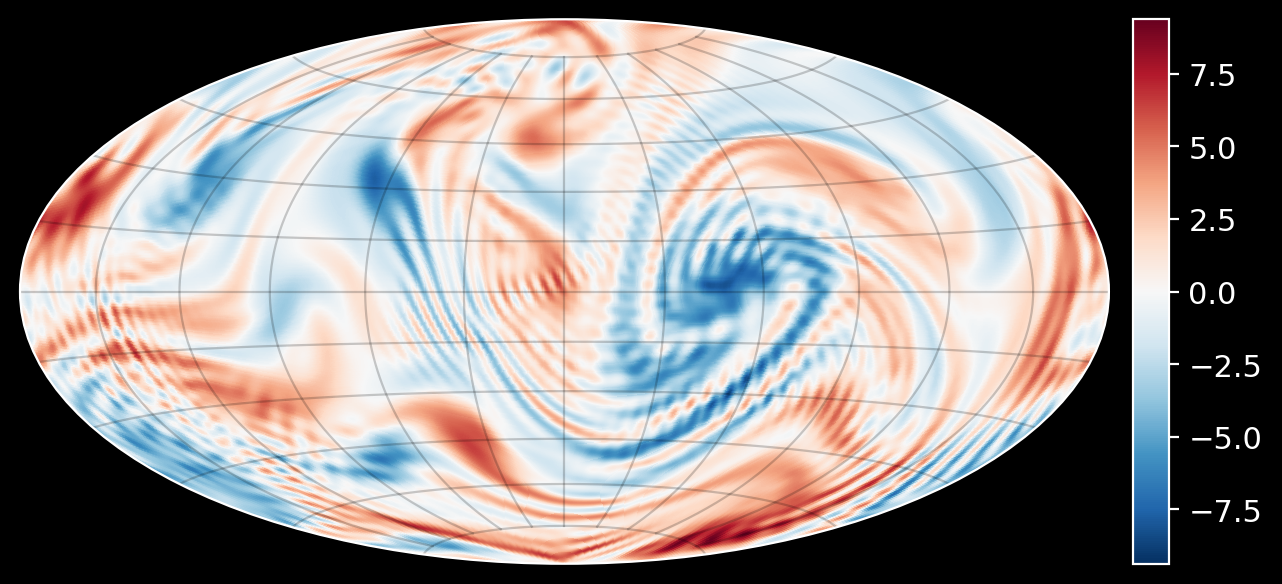

In [8]:
# Plot last state
with h5py.File(filename_gpu, 'r') as data:
    omega = data['state'][-1]
    qf.plot2(omega, projection='hammer', N=520, colorbar=True)
    #plt.savefig(f"output_{N}.png")

In [9]:
with h5py.File(filename_gpu, 'r') as data:
    anim = qf.create_animation2(filename_gpu.replace(".hdf5",".mp4"), data['state'], projection='mollweide', N=256)
anim

100%|██████████| 7/7 [00:01<00:00,  3.60 frames/s]


## Compare GPU solution to CPU

[0.00000000e+00 7.29596823e-09 1.07489996e-08 1.31139482e-08
 1.59168264e-08 1.89203975e-08 2.33898365e-08]


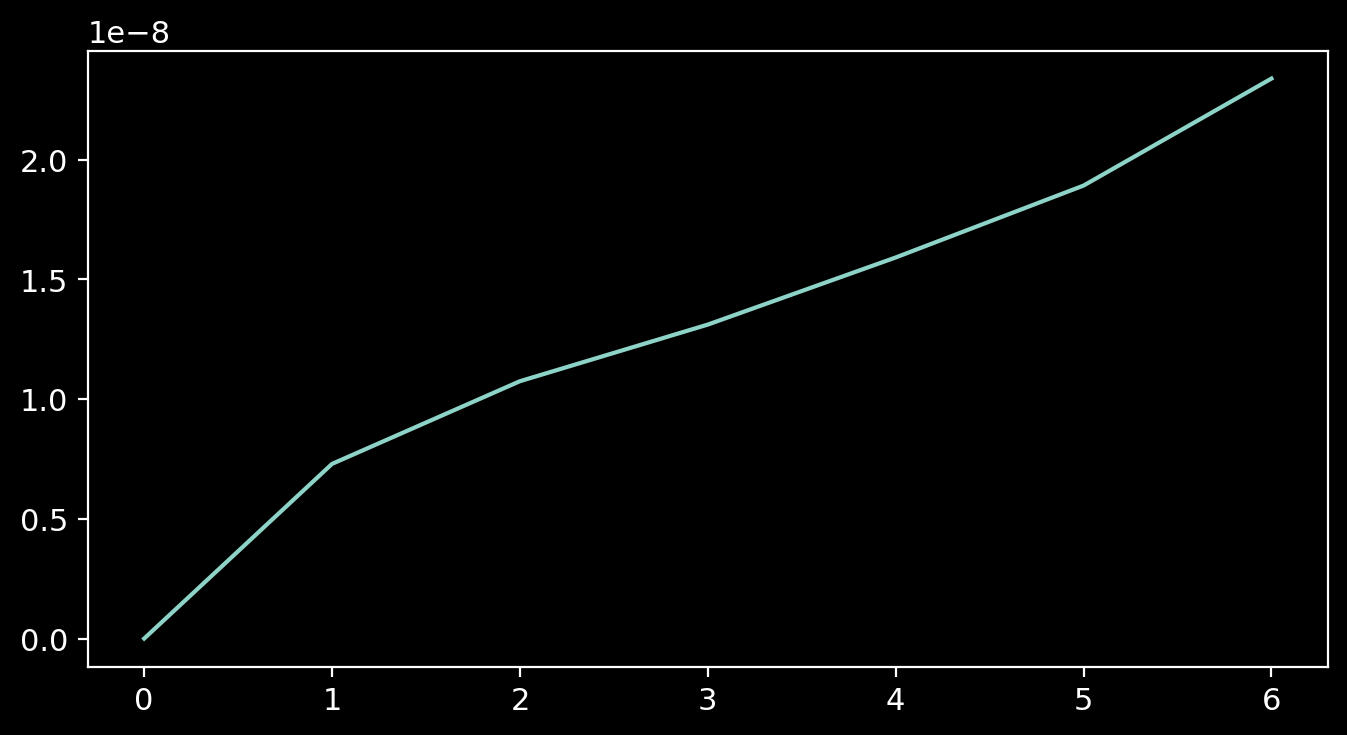

In [10]:
with h5py.File(filename_gpu, 'r') as data_gpu, h5py.File(filename_cpu, 'r') as data_cpu:
    diff = np.zeros(data_gpu['state'].shape[0])
    for k in range(data_gpu['state'].shape[0]):
        diff[k] = np.linalg.norm(data_cpu['state'][k]-data_gpu['state'][k])
    plt.figure(figsize=(8,4))
    plt.plot(diff)
    print(diff)
    plt.show()

## Check conservation of casimirs


7
7


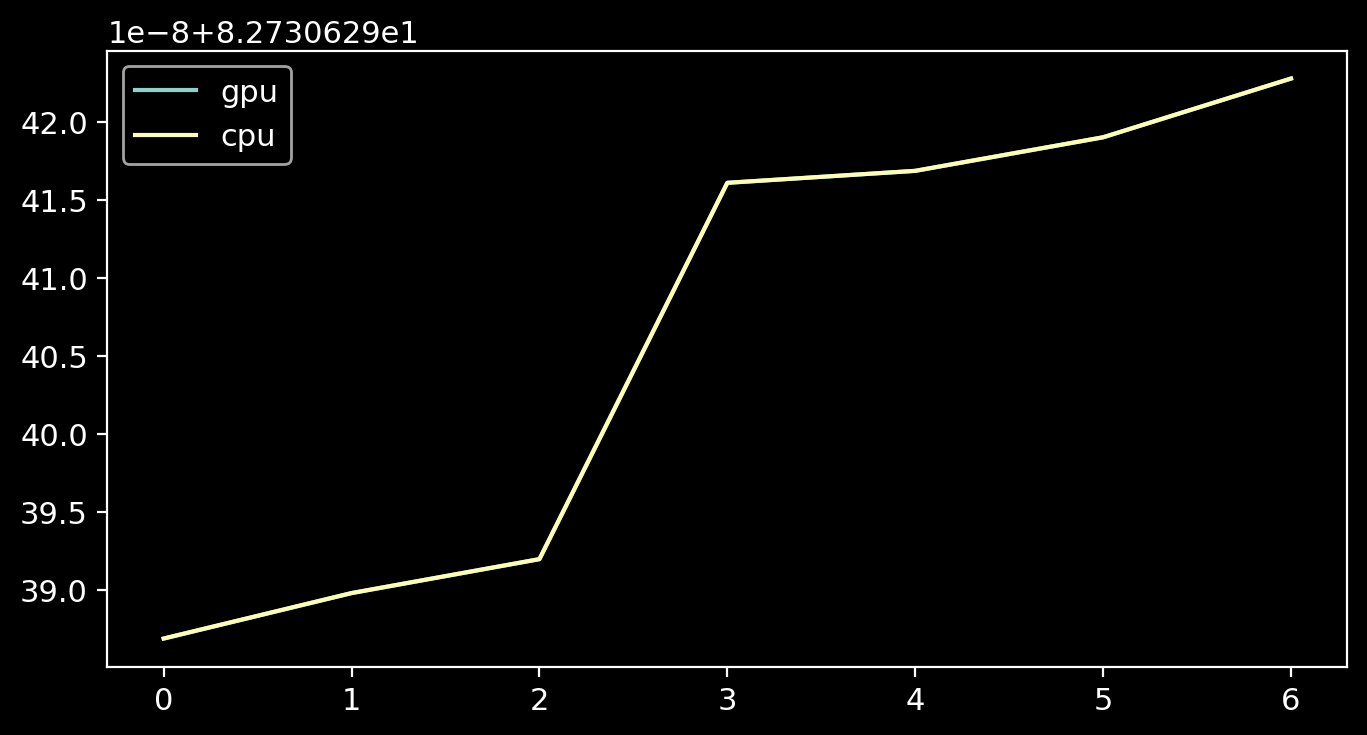

[0.00000000e+00 2.84217094e-14 0.00000000e+00 2.84217094e-14
 2.84217094e-14 9.94759830e-14 0.00000000e+00]


In [11]:
# Check conservation of casimirs

casimir_gpu = []
casimir_cpu = []
with h5py.File(filename_gpu, 'r') as data:
    print(data['state'].shape[0])
    for k in range(data['state'].shape[0]):
        omega = data['state'][k]
        casimir_gpu += [np.linalg.norm(omega)**2]
    casimir_gpu = np.asarray(casimir_gpu)
    plt.figure(figsize=(8,4))
    plt.plot(casimir_gpu, label="gpu")

with h5py.File(filename_cpu, 'r') as data:
    print(data['state'].shape[0])
    for k in range(data['state'].shape[0]): 
        omega = data['state'][k] # type: ignore
        casimir_cpu += [np.linalg.norm(omega)**2]
    casimir_cpu = np.asarray(casimir_cpu)
    plt.plot(casimir_cpu, label="cpu")

plt.legend()
plt.show()
print(np.abs(casimir_gpu-casimir_cpu))